In [321]:
import pandas as pd
import numpy as np
from collections import defaultdict

def merge_duplicate_columns(df):
    """
    Merges columns that are duplicates following the pattern:
    - Base column (e.g., "Oasis")
    - Kill variant (e.g., "Kill Oasis") 
    - Kills variant (e.g., "Kills Oasis")
    
    Priority: Base > Kills > Kill (first non-null value wins)
    """
    df = df.copy()
    column_groups = defaultdict(list)
    
    for col in df.columns:
        if col.startswith("Kill "):
            base_name = col[5:]
            column_groups[base_name].append(("kill", col))
        elif col.startswith("Kills "):
            base_name = col[6:]
            column_groups[base_name].append(("kills", col))
        else:
            column_groups[col].append(("base", col))
    
    columns_to_drop = []
    
    for base_name, variants in column_groups.items():
        if len(variants) > 1:
            base_col = None
            kills_col = None
            kill_col = None
            
            for variant_type, col_name in variants:
                if variant_type == "base":
                    base_col = col_name
                elif variant_type == "kills":
                    kills_col = col_name
                elif variant_type == "kill":
                    kill_col = col_name
            
            target_col = base_col or kills_col or kill_col
            
            for variant_type, col_name in variants:
                if col_name != target_col:
                    df[col_name] = df[col_name].replace(0, np.nan)
            
            if base_col and base_col != target_col:
                df[base_col] = df[base_col].replace(0, np.nan)
            
            merge_order = []
            if base_col: merge_order.append(base_col)
            if kills_col: merge_order.append(kills_col)  
            if kill_col: merge_order.append(kill_col)
            
            if len(merge_order) > 1:
                for i in range(1, len(merge_order)):
                    df[merge_order[0]] = df[merge_order[0]].fillna(df[merge_order[i]])
                    columns_to_drop.append(merge_order[i])
    
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    return df

### Removing problematic "Kein Rekord" lines

In [322]:
import os

def remove_kein_rekord_lines(directory_path="in-new/"):
    if not os.path.exists(directory_path):
        print(f"Directory '{directory_path}' not found.")
        return
    
    txt_files = [f for f in os.listdir(directory_path) if f.endswith('.txt')]
    
    if not txt_files:
        print(f"No .txt files found in '{directory_path}'")
        return
    
    processed_count = 0
    
    for filename in txt_files:
        file_path = os.path.join(directory_path, filename)
        
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                lines = file.readlines()
            
            original_count = len(lines)
            filtered_lines = [line for line in lines if '' not in line]
            removed_count = original_count - len(filtered_lines)
            
            if removed_count > 0:
                with open(file_path, 'w', encoding='utf-8') as file:
                    file.writelines(filtered_lines)
                print(f"Processed '{filename}': removed {removed_count} line(s)")
                processed_count += 1
            else:
                print(f"No changes needed for '{filename}'")
                
        except Exception as e:
            print(f"Error processing '{filename}': {e}")
    
    print(f"\nCompleted processing {len(txt_files)} file(s), {processed_count} file(s) modified.")

if __name__ == "__main__":
    remove_kein_rekord_lines()

Processed '__egE.txt': removed 5 line(s)
Processed 'Tammywood.txt': removed 24 line(s)
Processed 'BunnyKiko.txt': removed 2 line(s)
Processed 'SpeckyCut.txt': removed 3 line(s)
No changes needed for 'sirmigorius.txt'
Processed 'Hyxeed.txt': removed 17 line(s)
Processed 'demiu.txt': removed 24 line(s)
Processed 'SpinCrafter.txt': removed 7 line(s)
Processed 'NanamiElvi.txt': removed 16 line(s)
No changes needed for '_n3d.txt'
Processed 'Sebi1801.txt': removed 8 line(s)
No changes needed for 'AnzeigeGehtRaus.txt'
Processed 'JayMinInSane.txt': removed 24 line(s)
Processed 'Persidieus.txt': removed 14 line(s)
Processed 'N3XV.txt': removed 2 line(s)
Processed 'Wissender.txt': removed 5 line(s)
Processed 'Gryzes.txt': removed 3 line(s)
Processed 'jimmi4Life.txt': removed 2 line(s)
No changes needed for 'Gobo9.txt'
Processed 'Anni808.txt': removed 5 line(s)
Processed 'LeWi_100.txt': removed 5 line(s)
Processed '_Waldi_.txt': removed 4 line(s)
No changes needed for 'Grapfen.txt'
Processed 'Pix

In [323]:
import os
import re 
import pandas as pd
import seaborn as sns 
import numpy as np 
import chardet
import warnings


pointMiniGames = "Sammelwahn, Schießstand, Mauerfall, Survivalgames, Skywars, Lasertag, Minengefecht, Einer im Köcher, Paintball, Spleef, Buntes Chaos, Reihenfolge, Duelle, Turmroulette" 
timeMiniGames = "Wettrennen, Parkour, Pferderennen, Drachenflucht, Replika, Blockhüpfer, Todeswürfel, Freier Fall, Elytrarennen, Waffenfolge, Minenfeld, Kletterkönig, Ampelrennen, Hoch hinaus, Frostiger Pfad, Runterpurzeln"

miniGameList = ["1-Sammelwahn",
        "2-Schießstand",
        "3-Wettrennen",
        "4-Pferderennen",
        "5-Drachenflucht",
        "6-Parkour",
        "7-Hoch Hinaus",
        "8-Blockhüpfer",
        "9-Todeswürfel",
        "10-Freier Fall",
        "11-Elytrarennen",
        "12-Waffenfolge",
        "13-Minenfeld",
        "14-Kletterkönig",
        "15-Ampelrennen",
        "16-Replika",
        "17-Mauerfall",
        "18-Survivalgames",
        "19-Skywars",
        "20-Lasertag",
        "21-Minengefecht",
        "22-OITC",
        "23-Paintball",
        "24-Spleef",
        "25-Buntes Chaos",
        "26-Reihenfolge",
        "27-Duelle",
        "28-Frotiger Pfad",
        "29-Runterpurzeln",
        "30-Turmroulette"]

inactiveMinigames = ["Paintball", "Freier Fall"]

def getPlayerPaths():
    file_list = os.listdir('in-new')
    return file_list

def read_file(file, enc='auto'):

    with open('in-new/' + file, 'rb') as f:
        raw_data = f.read()
    
    # Detect the encoding
    if enc == 'auto':
        # detected = chardet.detect(raw_data)
        encoding = 'utf-8'
    #encoding = 'iso-8859-2'
    encoding = 'utf-8'

    # debug print(f"Detected encoding for {file}: {encoding}")
    
    # Now read the file with the detected encoding
    with open('in-new/' + file, 'r', encoding=encoding) as f:
        data = f.read().replace('TooltipEvent, ', '')
    
    return data

def getRecordData(playerPath, minigame, enc='auto'):
    data = read_file(playerPath, enc=enc).split('\n')
    for line in data: 
        if minigame in line: 
            minigameData = line
            minigameData = minigameData.replace(minigame, '').strip()
            return minigameData  # return the data instead of printing it

def create_dataframe(input_string, minigame):

    # Define regular expression pattern to match map names and times
    pattern = r'(\w+\s?\w+)\s*:\s*(?:(\d+)\s*min\s*)?(?:(\d+)\s*s\s*)?(\d+)\s*ms'

    # Find all matches in the input string
    try: matches = re.findall(pattern, input_string)
    except: matches = None

    # Initialize data dictionary to store map names and times
    data = {}

    # Iterate over matches and populate data dictionary
    if matches: 
        for match in matches:
            map_name = match[0]
            minutes = int(match[1] or 0)
            seconds = int(match[2] or 0) + int(match[3]) / 1000
            time_seconds = minutes * 60 + seconds
            data[map_name] = time_seconds
    else: return pd.DataFrame()

    # Create DataFrame from data dictionary
    df = pd.DataFrame(data, index=[0])


    return df


def createPointDataframe(input_string, minigame):
    # Define regular expression pattern to match map names and times
    pattern = r'(\w+\s?\w+)\s*:\s*(\d+)'

    # Find all matches in the input string
    matches = re.findall(pattern, input_string)

    # Initialize data dictionary to store map names and times
    data = {}

    # Iterate over matches and populate data dictionary
    for match in matches:
        map_name = match[0]
        time_value = int(match[1])
        data[map_name] = time_value

    # Create DataFrame from data dictionary
    df = pd.DataFrame(data, index=[0])
    return df.fillna(0)


paths = getPlayerPaths()

def getRecordsDataframe(minigame='Wettrennen', save=False, log=False, html=False, encoding='auto'):

    if minigame in inactiveMinigames:
        return None
    
    outDf = pd.DataFrame()

    if log:
        print(f'processing {minigame}...')

    if minigame in pointMiniGames: 
        pass
    elif minigame in timeMiniGames:
        pass
    else: 
        ValueError('Not a valid minigame name')

    for i in paths:
        if minigame in timeMiniGames:
            df = create_dataframe(getRecordData(playerPath=i, minigame=minigame, enc='auto'), minigame)
        if minigame in pointMiniGames:
            try: 
                df = createPointDataframe(getRecordData(playerPath=i, minigame=minigame, enc='auto'), minigame)
                df.fillna(0, inplace=True)
            except: 
                continue

        if df is not None:  
            df.index = [i.replace('.txt', '')]
            outDf = pd.concat([outDf, df])

    outPath = 'out/' + minigame + '.json'

    '''
        Minigame Specific changes to the df
    '''
    with pd.option_context('mode.chained_assignment', None):
        try:
            if ("Replika" in minigame): 

                replikaDf = outDf 

                # fillNa columns without "ms" with values from "ms", e.g. ms Arrow -> Arrow, then drop "ms" columns

                try:
                    replikaDf["Arrow"] = replikaDf["Arrow"].fillna(replikaDf["ms Arrow"])
                    replikaDf["Cow"] = replikaDf["Cow"].fillna(replikaDf["ms Cow"])
                    replikaDf["Deadpool"] = replikaDf["Deadpool"].fillna(replikaDf["ms Deadpool"])
                    replikaDf["Doge"] = replikaDf["Doge"].fillna(replikaDf["ms Doge"])
                    replikaDf["Sonic"] = replikaDf["Sonic"].fillna(replikaDf["ms Sonic"])

                    replikaDf.drop(columns=["ms Arrow", "ms Cow", "ms Deadpool", "ms Doge", "ms Sonic"], inplace=True)
                except: print("Warning, >ms< columns not found in ReplikaDf")

                replikaDf.fillna(25, inplace=True) # assigning a value to a never-played-before pattern, 17 perturbs worse player order and alt account stats lol, 27 is probably too much, difficult to choose an appropriate value here
                row_sums = replikaDf.sum(axis=1)
                
                # Append the sum as a new column
                replikaDf['Sum'] = row_sums

                # Re-indexing
                replikaDf = replikaDf.reindex(sorted(replikaDf.columns), axis=1)
            
                # Move 'Sum' column to the first position
                cols = replikaDf.columns.tolist()
                cols = ['Sum'] + [col for col in cols if col != 'Sum']
                replikaDf = replikaDf[cols]

                # replace 25 values again with None
                replikaDf = replikaDf.replace(25, np.nan)

                # replikaDf = replikaDf.reindex(sorted(replikaDf.columns), axis=1)


                # Removing player data with too many NaNs (players that haven't played most of the patterns)
                # replikaDf = replikaDf.drop(columns=["Ritokii", "Feinberg", "Sebi1801"])

                outDf = replikaDf

            if ("Sammelwahn" in minigame):

                row_sums = outDf.sum(axis=1)

                # Append the sum as a new column
                outDf['Sum'] = row_sums

                # Re-indexing
                outDf = outDf.reindex(sorted(outDf.columns), axis=1)

                # Move 'Sum' column to the first position
                cols = outDf.columns.tolist()
                cols = ['Sum'] + [col.lstrip() for col in cols if col != 'Sum']
                outDf = outDf[cols]

                # remove "Punkte" from all columns
                outDf.columns = outDf.columns.str.replace('Punkte', '')
            
            if ("Buntes" in minigame):
                print(outDf.columns)

            if ("Lasertag" in minigame):
                outDf = merge_duplicate_columns(outDf)

            if ("Einer im Köcher" in minigame):
                outDf = merge_duplicate_columns(outDf)
                
            if ("Paintball" in minigame):
                outDf = merge_duplicate_columns(outDf)

            if ("Skywars" in minigame):
                outDf = merge_duplicate_columns(outDf)

            if ("Survivalgames" in minigame and True):
                outDf = merge_duplicate_columns(outDf)

            if ("Minengefecht" in minigame):
                outDf = merge_duplicate_columns(outDf)

            if ("Mauerfall" in minigame):
                outDf = merge_duplicate_columns(outDf)

            if ("Schie" in minigame):
                outDf["Punkte City"] = outDf["Punkte City"].replace(0, np.nan)
                outDf["City"] = outDf["City"].replace(0, np.nan)

                outDf["temp1"] = outDf["City"].fillna(outDf["Punkte City"])
                try: outDf.drop(columns=["City", "Punkte City"], inplace=True)
                except: pass

                outDf["City"] = outDf["temp1"]

                outDf["Punkte Jungle"] = outDf["Punkte Jungle"].replace(0, np.nan)

                outDf["temp1"] = outDf["Punkte Jungle"]
                try: outDf.drop(columns=["Punkte Jungle"], inplace=True)
                except: pass

                outDf["Jungle"] = outDf["temp1"]

                outDf.drop(columns=["temp1"], inplace=True)
                
            if ("Frostiger" in minigame): 
                # remove values bigger than 100 with nan
                outDf = outDf.where(outDf < 100, np.nan)

            if ("Duel" in minigame): 
                outDf = outDf.where(outDf > 10, 0.0)

            if ("Einer im Köcher" in minigame):
                outDf = merge_duplicate_columns(outDf)

            if ("Buntes" in minigame):
                
                outDf = outDf.fillna(0)
                try: 
                    outDf['temp1'] = outDf["Runden Cyberpunk"].fillna(outDf["Cyberpunk"])
                    outDf.drop(columns=["Runden Cyberpunk", "Cyberpunk"], inplace=True)

                    outDf['Cyberpunk'] = outDf['temp1']

                    outDf.drop(columns=["temp1"], inplace=True)
                except: pass

            if ("Pferd" in minigame):
                outDf["s Arena"] = outDf["s Arena"].replace(0, np.nan)
                outDf["Wario's Arena"] = outDf["s Arena"]

                outDf.drop(columns=["s Arena"], inplace=True)


            # Sorting columns alphabetically for any outDf except if minigame == "Replika" (sum column)
            
            if ("Replika" not in minigame):
                if ("Sammelwahn" not in minigame):
                    outDf = outDf.reindex(sorted(outDf.columns), axis=1)
        except: pass

    '''
        debugging options and html export for figure generation
    '''
        
    if save: 
        if "Replika" in minigame: 
            json_df = outDf.iloc[:, 1:]
            json_df.T.to_json(outPath)
        
        else: outDf.T.to_json(outPath) 


    if html: 
        log = False 
        html_table = ""
        if ("Drache" in minigame) or ("Mini" in minigame) or ("Köcher" in minigame) or ("Lasertag" in minigame) or ("Minengef" in minigame) or ("Paint" in minigame) or ("Reihenf" in minigame) or ("Sammel" in minigame) or ("Schießs" in minigame) or ("Spleef" in minigame) or ("Mauerfall" in minigame): 
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('<td>NaN</td>', '<td>0</td>').replace('.0</td>', '</td>').replace('Tötungen Asia', 'Asia').replace('Tötungen', '').replace('Punkte', '')
        elif ("Pferde" in minigame):
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('>9', '>09').replace('>8', '>08').replace('>7', '>07').replace('>6', '>06').replace('>5', '>05').replace('>4', '>04').replace('s Arena', "Wario's Arena").replace('>Cheep B', ">Cheep Cheep B")
        elif ("Replika" in minigame): 
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('>9.', '>09.').replace('>8.', '>08.').replace('>7.', '>07.').replace('>6.', '>06.').replace('>5.', '>05.').replace('>4.', '>04.').replace('>3.', '>03.').replace('>ms ','>').replace('>30.000','>None')
        elif ("Wettrennen" in minigame):
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('Punkte', '').replace('Runden', '').replace('Blossom', 'Cherry Blossom').replace('>3', '>03').replace('>4', '>04').replace('>5', '>05').replace('>6', '>06').replace('>7', '>07').replace('>8', '>08').replace('>9', '>09')
        elif ("Elytra" in minigame):
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('Punkte', '').replace('Runden', '').replace('>9', '>09').replace('>8', '>08').replace('>7', '>07').replace('>6', '>06').replace('>5', '>05').replace('>4', '>04').replace('>3', '>03')
        else: 
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('Punkte', '').replace('Runden', '').replace('Blossom', 'Cherry Blossom')
        
        print(html_table)

    if log: 
        print(f'{minigame} processed and saved to {outPath}')

    if html == False: 
        return outDf
    
import json

def export_records_json(minigames):
    try:
        all_records = []
        for minigame in sorted(minigames):
            if minigame not in inactiveMinigames:
                records = getRecordsDataframe(minigame=minigame, save=False, log=False, encoding='auto'
                                            )
                
                # Print column names for debugging
                print(f"Columns for {minigame}: {records.columns.tolist()}")
                
                for player_name, row in records.iterrows():
                    record = {
                        "name": player_name,
                        "minigame": minigame,
                        "scores": {}
                    }
                    
                    # Assuming all non-index columns are map names
                    for map_name in records.columns:
                        score = row[map_name]
                        if pd.notna(score):  # Only include non-null scores
                            record["scores"][map_name] = score
                    
                    # Calculate and add the best score
                    if record["scores"]:
                        record["best_score"] = max(record["scores"].values())
                    
                    all_records.append(record)
            
            return json.dumps(all_records, indent=2)
    except: 
        print("Error in export_records_json for minigame: " + minigame)
        return None

def jsonExport(debug=False):

    minigames = (pointMiniGames + ', ' + timeMiniGames).split(', ')

    if debug: print(f"processing {minigames}")
    json_data = export_records_json(minigames)

    if debug: print("json_data has a length of: " + str(len(json_data)))

    # Save as separate file
    with open('records_data.json', 'w') as f:
        if json_data is not None:
            f.write(json_data)
        else: pass

    print("Data exported successfully to records_data.json")


def assembleHTML():

    # HTML assembly #

    frontWrapperList = []
    x = 0
    endWrapper = "</table> </div>"

    for i in sorted((pointMiniGames + ', ' + timeMiniGames).split(', ')):
        x = x + 1
        strX = str(x)
        frontWrapperList.append('<!-- Table: ' + i + ' --> <div id="table' + strX + '" style="display:none;"> <table id="dataframe' + strX + '" class="display nowrap">')

    print('<div class="table-container">')
    x = 0
    for i in sorted((pointMiniGames + ', ' + timeMiniGames).split(', ')):
        print(frontWrapperList[x])
        getRecordsDataframe(minigame=i, save=True, log=False, html=True, encoding="auto")
        print(endWrapper)
        x = x + 1
    print('</div>')

### Checking File Encodings (must be utf-8)

In [324]:
import os
import chardet
from collections import defaultdict
import pandas as pd

def check_file_encodings(directory='in-new'):
    """
    Check the encoding of all files in the specified directory.
    Returns a DataFrame with file information and detailed encoding analysis.
    """
    # Store results
    results = []
    
    # Get list of files
    files = os.listdir(directory)
    
    for filename in files:
        filepath = os.path.join(directory, filename)
        
        # Read file in binary mode
        with open(filepath, 'rb') as f:
            raw_data = f.read()
            
        # Detect encoding
        detection = chardet.detect(raw_data)
        
        # Try to decode with UTF-8
        is_utf8 = True
        try:
            raw_data.decode('utf-8')
        except UnicodeDecodeError:
            is_utf8 = False
            
        # Get file size
        file_size = os.path.getsize(filepath)
            
        results.append({
            'filename': filename,
            'detected_encoding': detection['encoding'],
            'confidence': detection['confidence'],
            'is_utf8': is_utf8,
            'file_size': file_size
        })
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Add summary statistics
    print("\nSummary Statistics:")
    print("-" * 50)
    print(f"Total files: {len(files)}")
    print(f"Files that are UTF-8: {df['is_utf8'].sum()}")
    print(f"Files that are not UTF-8: {len(files) - df['is_utf8'].sum()}")
    print("\nDetected encodings distribution:")
    print(df['detected_encoding'].value_counts())
    
    # Show problematic files
    print("\nFiles that are not UTF-8:")
    problematic_files = df[~df['is_utf8']]
    if len(problematic_files) > 0:
        print(problematic_files[['filename', 'detected_encoding', 'confidence']])
    else:
        print("None found")
        
    return df

# Run the analysis
encoding_analysis = check_file_encodings()

try: os.remove('in-new/.DS_Store')
except: pass


Summary Statistics:
--------------------------------------------------
Total files: 241
Files that are UTF-8: 241
Files that are not UTF-8: 0

Detected encodings distribution:
detected_encoding
utf-8         228
ISO-8859-1      1
MacRoman        1
ascii           1
Name: count, dtype: int64

Files that are not UTF-8:
None found


In [325]:
# assembleHTML() #for old DataTables implementation

In [326]:
# new JSON-base d Tabulator Implementation

jsonExport()

Columns for Ampelrennen: ['Castle', 'Street']
Data exported successfully to records_data.json


In [327]:
import json
import pandas as pd
import os

def load_existing_uuids(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            return json.load(f)
    return {}

def save_uuids(uuids, file_path):
    with open(file_path, 'w') as f:
        json.dump(uuids, f, indent=2)

def export_uuids(minigames, output_file):
    existing_uuids = load_existing_uuids(output_file)
    new_players = set()

    for minigame in sorted(minigames):
        if minigame not in inactiveMinigames:
            records = getRecordsDataframe(minigame=minigame, save=False, log=False)
            
            for player_name in records.index:
                if player_name not in existing_uuids:
                    new_players.add(player_name)

    if new_players:
        print("New players found without UUIDs:")
        for player in new_players:
            print(player)
        print("\nPlease enter UUIDs for these players (or press Enter to skip):")
        for player in new_players:
            uuid = input(f"{player}: ").strip()
            if uuid:
                existing_uuids[player] = uuid

    save_uuids(existing_uuids, output_file)
    print(f"UUIDs exported successfully to {output_file}")

def export_records_json(minigames, records_file):
    all_records = []
    for minigame in sorted(minigames):
        records = getRecordsDataframe(minigame=minigame, save=False, log=False)

        if records is None: continue
        
        for player_name, row in records.iterrows():
            record = {
                "name": player_name,
                "minigame": minigame,
                "scores": {}
            }
            
            for map_name in records.columns:
                score = row[map_name]
                if pd.notna(score):  # Only include non NaN scores
                    record["scores"][map_name] = score.item()
            
            if record["scores"]:
                record["best_score"] = max(record["scores"].values())
            
            all_records.append(record)
    
    with open(records_file, 'w') as f:
        json.dump(all_records, f, indent=2)

    print(f"Records exported successfully to {records_file}")

minigames = (pointMiniGames + ', ' + timeMiniGames).split(', ')
export_uuids(minigames, 'player_uuids.json')
export_records_json(minigames, 'records_data.json')

Index(['Structure', 'Runden Cyberpunk', 'Cyberpunk'], dtype='object')
UUIDs exported successfully to player_uuids.json
Index(['Structure', 'Runden Cyberpunk', 'Cyberpunk'], dtype='object')
Records exported successfully to records_data.json


In [328]:
import shutil
import datetime

# save Elytrarennen Snapshot for later analysis 

current_date = datetime.datetime.now().strftime("%Y-%m-%d")
# shutil.copy("out/Elytrarennen.json", f"out/snapshots/Elytrarennen--{current_date}--.json")

In [329]:
type(str(getRecordsDataframe(minigame='Drachenflucht', save=False, log=False, html=True)))

  <thead>    <tr style="text-align: right;">      <th></th>      <th>Desert</th>      <th>Factory</th>      <th>Hills</th>      <th>Temple</th>    </tr>  </thead>  <tbody>    <tr>      <th>__egE</th>      <td>0</td>      <td>0</td>      <td>0</td>      <td>0</td>    </tr>    <tr>      <th>Tammywood</th>      <td>0</td>      <td>0</td>      <td>0</td>      <td>0</td>    </tr>    <tr>      <th>BunnyKiko</th>      <td>0</td>      <td>80.741</td>      <td>99.179</td>      <td>94.988</td>    </tr>    <tr>      <th>SpeckyCut</th>      <td>97.187</td>      <td>8.613</td>      <td>103.752</td>      <td>0</td>    </tr>    <tr>      <th>sirmigorius</th>      <td>126.008</td>      <td>117.405</td>      <td>119.704</td>      <td>56.559</td>    </tr>    <tr>      <th>Hyxeed</th>      <td>0</td>      <td>0</td>      <td>0</td>      <td>0</td>    </tr>    <tr>      <th>demiu</th>      <td>0</td>      <td>0</td>      <td>0</td>      <td>0</td>    </tr>    <tr>      <th>SpinCrafter</th>      <td>0</td>

str

In [330]:
for i in sorted((pointMiniGames + ', ' + timeMiniGames).split(', ')): print(i)


Ampelrennen
Blockhüpfer
Buntes Chaos
Drachenflucht
Duelle
Einer im Köcher
Elytrarennen
Freier Fall
Frostiger Pfad
Hoch hinaus
Kletterkönig
Lasertag
Mauerfall
Minenfeld
Minengefecht
Paintball
Parkour
Pferderennen
Reihenfolge
Replika
Runterpurzeln
Sammelwahn
Schießstand
Skywars
Spleef
Survivalgames
Todeswürfel
Turmroulette
Waffenfolge
Wettrennen


In [331]:
getRecordsDataframe(minigame='Replika').sort_values(by='Sum', ascending=True).head(10)

,Sum,Alien,Among Us,Apple,Arrow,Baby Yoda,Bee,Blinky,Block,Blue Monster,...,Water Temple,Windows,Wizard,YouTube,Zombie,muss los,of Meat,omb,ppHop 1,ppHop 2
Allooy,1377.544,14.122,13.361,10.542,8.888,9.046,6.799,10.905,22.400,12.630,...,7.927,10.789,10.960,11.304,13.471,13.521,9.860,6.728,11.154,12.550
_n3d,1466.965,11.708,14.664,10.737,9.394,9.593,10.452,11.676,21.904,18.913,...,9.958,13.696,11.405,14.656,13.622,15.769,10.120,7.909,13.037,14.291
cediiiiii_10,1671.824,24.481,14.679,10.893,10.076,10.940,10.688,13.285,NaN,14.825,...,12.187,11.434,12.676,11.998,16.227,14.803,11.127,9.433,17.488,14.512
Gobo9,1715.313,NaN,16.946,11.615,9.987,10.595,9.059,16.549,NaN,16.911,...,11.548,13.581,14.286,13.306,16.559,16.430,11.513,9.006,15.861,13.471
Luxemburq,1739.806,18.107,18.475,14.176,12.654,12.328,11.268,15.212,30.386,15.924,...,12.424,13.572,13.944,15.380,19.276,16.365,11.889,9.899,15.625,13.401
Ex4cted,1759.138,23.535,17.132,18.033,10.543,15.045,9.432,17.919,33.323,17.569,...,11.617,12.076,15.105,12.824,17.623,18.637,12.064,10.254,15.330,12.843
Muniix,1794.438,18.448,17.772,14.385,10.877,11.788,10.369,16.164,32.211,17.586,...,12.048,12.974,15.511,13.269,16.184,16.248,11.734,12.872,16.924,17.129
Teesily,1905.291,NaN,16.364,15.069,10.981,12.436,14.960,19.060,NaN,18.444,...,12.634,15.376,13.387,13.953,17.839,16.880,17.019,10.118,16.604,16.656
Fflopse,1953.511,NaN,20.522,18.257,11.809,14.733,11.767,20.255,NaN,16.449,...,13.989,12.863,14.457,13.465,13.918,17.453,13.366,11.788,17.211,18.293
PedroZockt,1972.368,NaN,16.777,18.682,12.723,12.779,11.268,17.098,NaN,18.044,...,15.487,13.008,18.424,12.337,16.269,19.726,14.157,9.768,16.034,15.067


In [332]:
getRecordsDataframe(minigame='Buntes Chaos')

Index(['Structure', 'Runden Cyberpunk', 'Cyberpunk'], dtype='object')


,Cyberpunk,Structure
__egE,25.0,22.0
BunnyKiko,16.0,19.0
SpeckyCut,19.0,23.0
sirmigorius,34.0,23.0
Hyxeed,0.0,0.0
...,...,...
Lubottus,26.0,36.0
Nervigerr,25.0,18.0
lolisamakun,30.0,19.0
Martomias,29.0,33.0


In [333]:
getRecordsDataframe(minigame='Replika').sort_values(by='Sum', ascending=True)['Sum'].mean()/102 # mean time per pattern for all players

np.float64(27.00198002603531)

In [334]:
getRecordsDataframe(minigame='Replika').sort_values(by='Sum', ascending=True)['Sum'].head(10).mean()/102 # mean time per pattern for top 10 players -> this value is used to fill NaN for sum column

np.float64(17.01588039215686)

In [335]:
getRecordData(playerPath=paths[0], minigame='Wettrennen')

'Islands :  1 min  14 s  463 ms Cyberpunk :  1 min  27 s  445 ms Cherry Blossom Canyon :  1 min  33 s  315 ms Green Hills :  1 min  09 s  098 ms'

In [336]:
# for i in sorted((pointMiniGames + ', ' + timeMiniGames).split(', ')): getRecordsDataframe(minigame=i, save=False, log=False, html=True)

In [337]:
getRecordsDataframe(minigame="Replika", save=False, log=False, html=False).loc['Gobo9']

Sum         1715.313
Alien            NaN
Among Us      16.946
Apple         11.615
Arrow          9.987
              ...   
muss los      16.430
of Meat       11.513
omb            9.006
ppHop 1       15.861
ppHop 2       13.471
Name: Gobo9, Length: 117, dtype: float64

/var/folders/xt/01bddk3n7wg7076w11mqj8640000gn/T/ipykernel_11219/884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/xt/01bddk3n7wg7076w11mqj8640000gn/T/ipykernel_11219/884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/xt/01bddk3n7wg7076w11mqj8640000gn/T/ipykernel_11219/884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Index(['Structure', 'Runden Cyberpunk', 'Cyberpunk'], dtype='object')


/var/folders/xt/01bddk3n7wg7076w11mqj8640000gn/T/ipykernel_11219/884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/xt/01bddk3n7wg7076w11mqj8640000gn/T/ipykernel_11219/884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/xt/01bddk3n7wg7076w11mqj8640000gn/T/ipykernel_11219/884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/xt/01bddk3n7wg7076w11mqj8640000gn/T/ipykernel_11219/884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/xt/01bddk3n7wg7076w11mqj8640000gn/T/ipykernel_11219/884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number

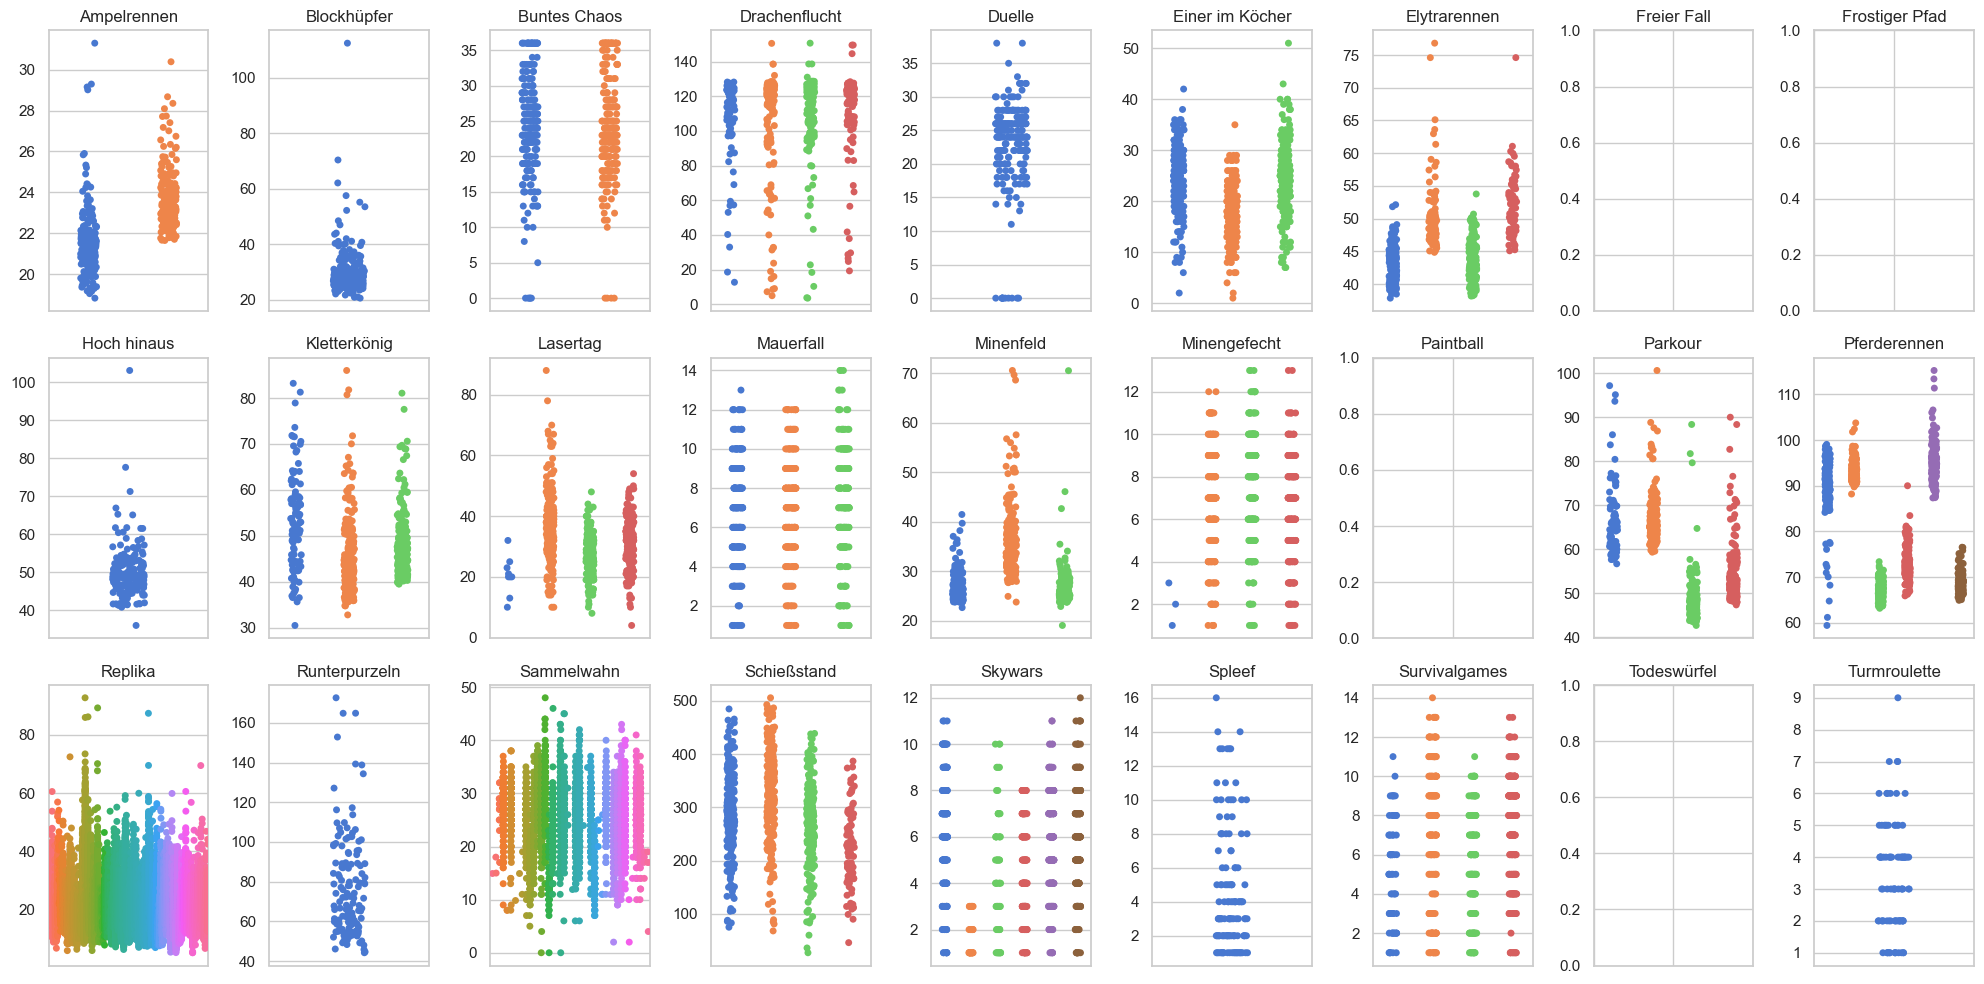

In [338]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted")

# List of minigames to plot
minigames = sorted((pointMiniGames + ', ' + timeMiniGames).split(', '))  # Add more minigames as needed

# remove "Reihenfolge" from the list
minigames.remove("Reihenfolge")

fig, ax = plt.subplots(ncols=9, nrows=3, figsize=[20, 10])

# Flatten the axes array to iterate over it easily
ax = ax.flatten()

# def createSmallSwarmPlots():
    # Create swarm plots for each minigame



for i, minigame in enumerate(minigames):
    data = getRecordsDataframe(minigame=minigame)
    if minigame in "Replika, Sammelwahn": 
        data = data.drop(columns=['Sum'])
    if i == 27: break 
    sns.stripplot(data=data, ax=ax[i])
    ax[i].set_title(f"{minigame}")
    ax[i].set_ylabel("")

    # Angle x-labels by 45 degrees
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

    # Hide overlapping x-labels
    plt.setp(ax[i].get_xticklabels(), visible=False)
    for label in ax[i].get_xticklabels():
        label.set_visible(False)
        if label.get_text() == '':
            continue
        if ax[i].xaxis.get_major_ticks()[-1].label1.get_window_extent().bounds[2] > ax[i].get_xlim()[1]:
            label.set_visible(False)
        elif label.get_window_extent().bounds[1] < 0:
            label.set_visible(False)

# Hide any remaining empty subplots
for i in range(len(minigames), len(ax)):
    ax[i].axis('off')

# createSmallSwarmPlots()

plt.tight_layout()
plt.show()

# plt.savefig('out/allSwarm.png')


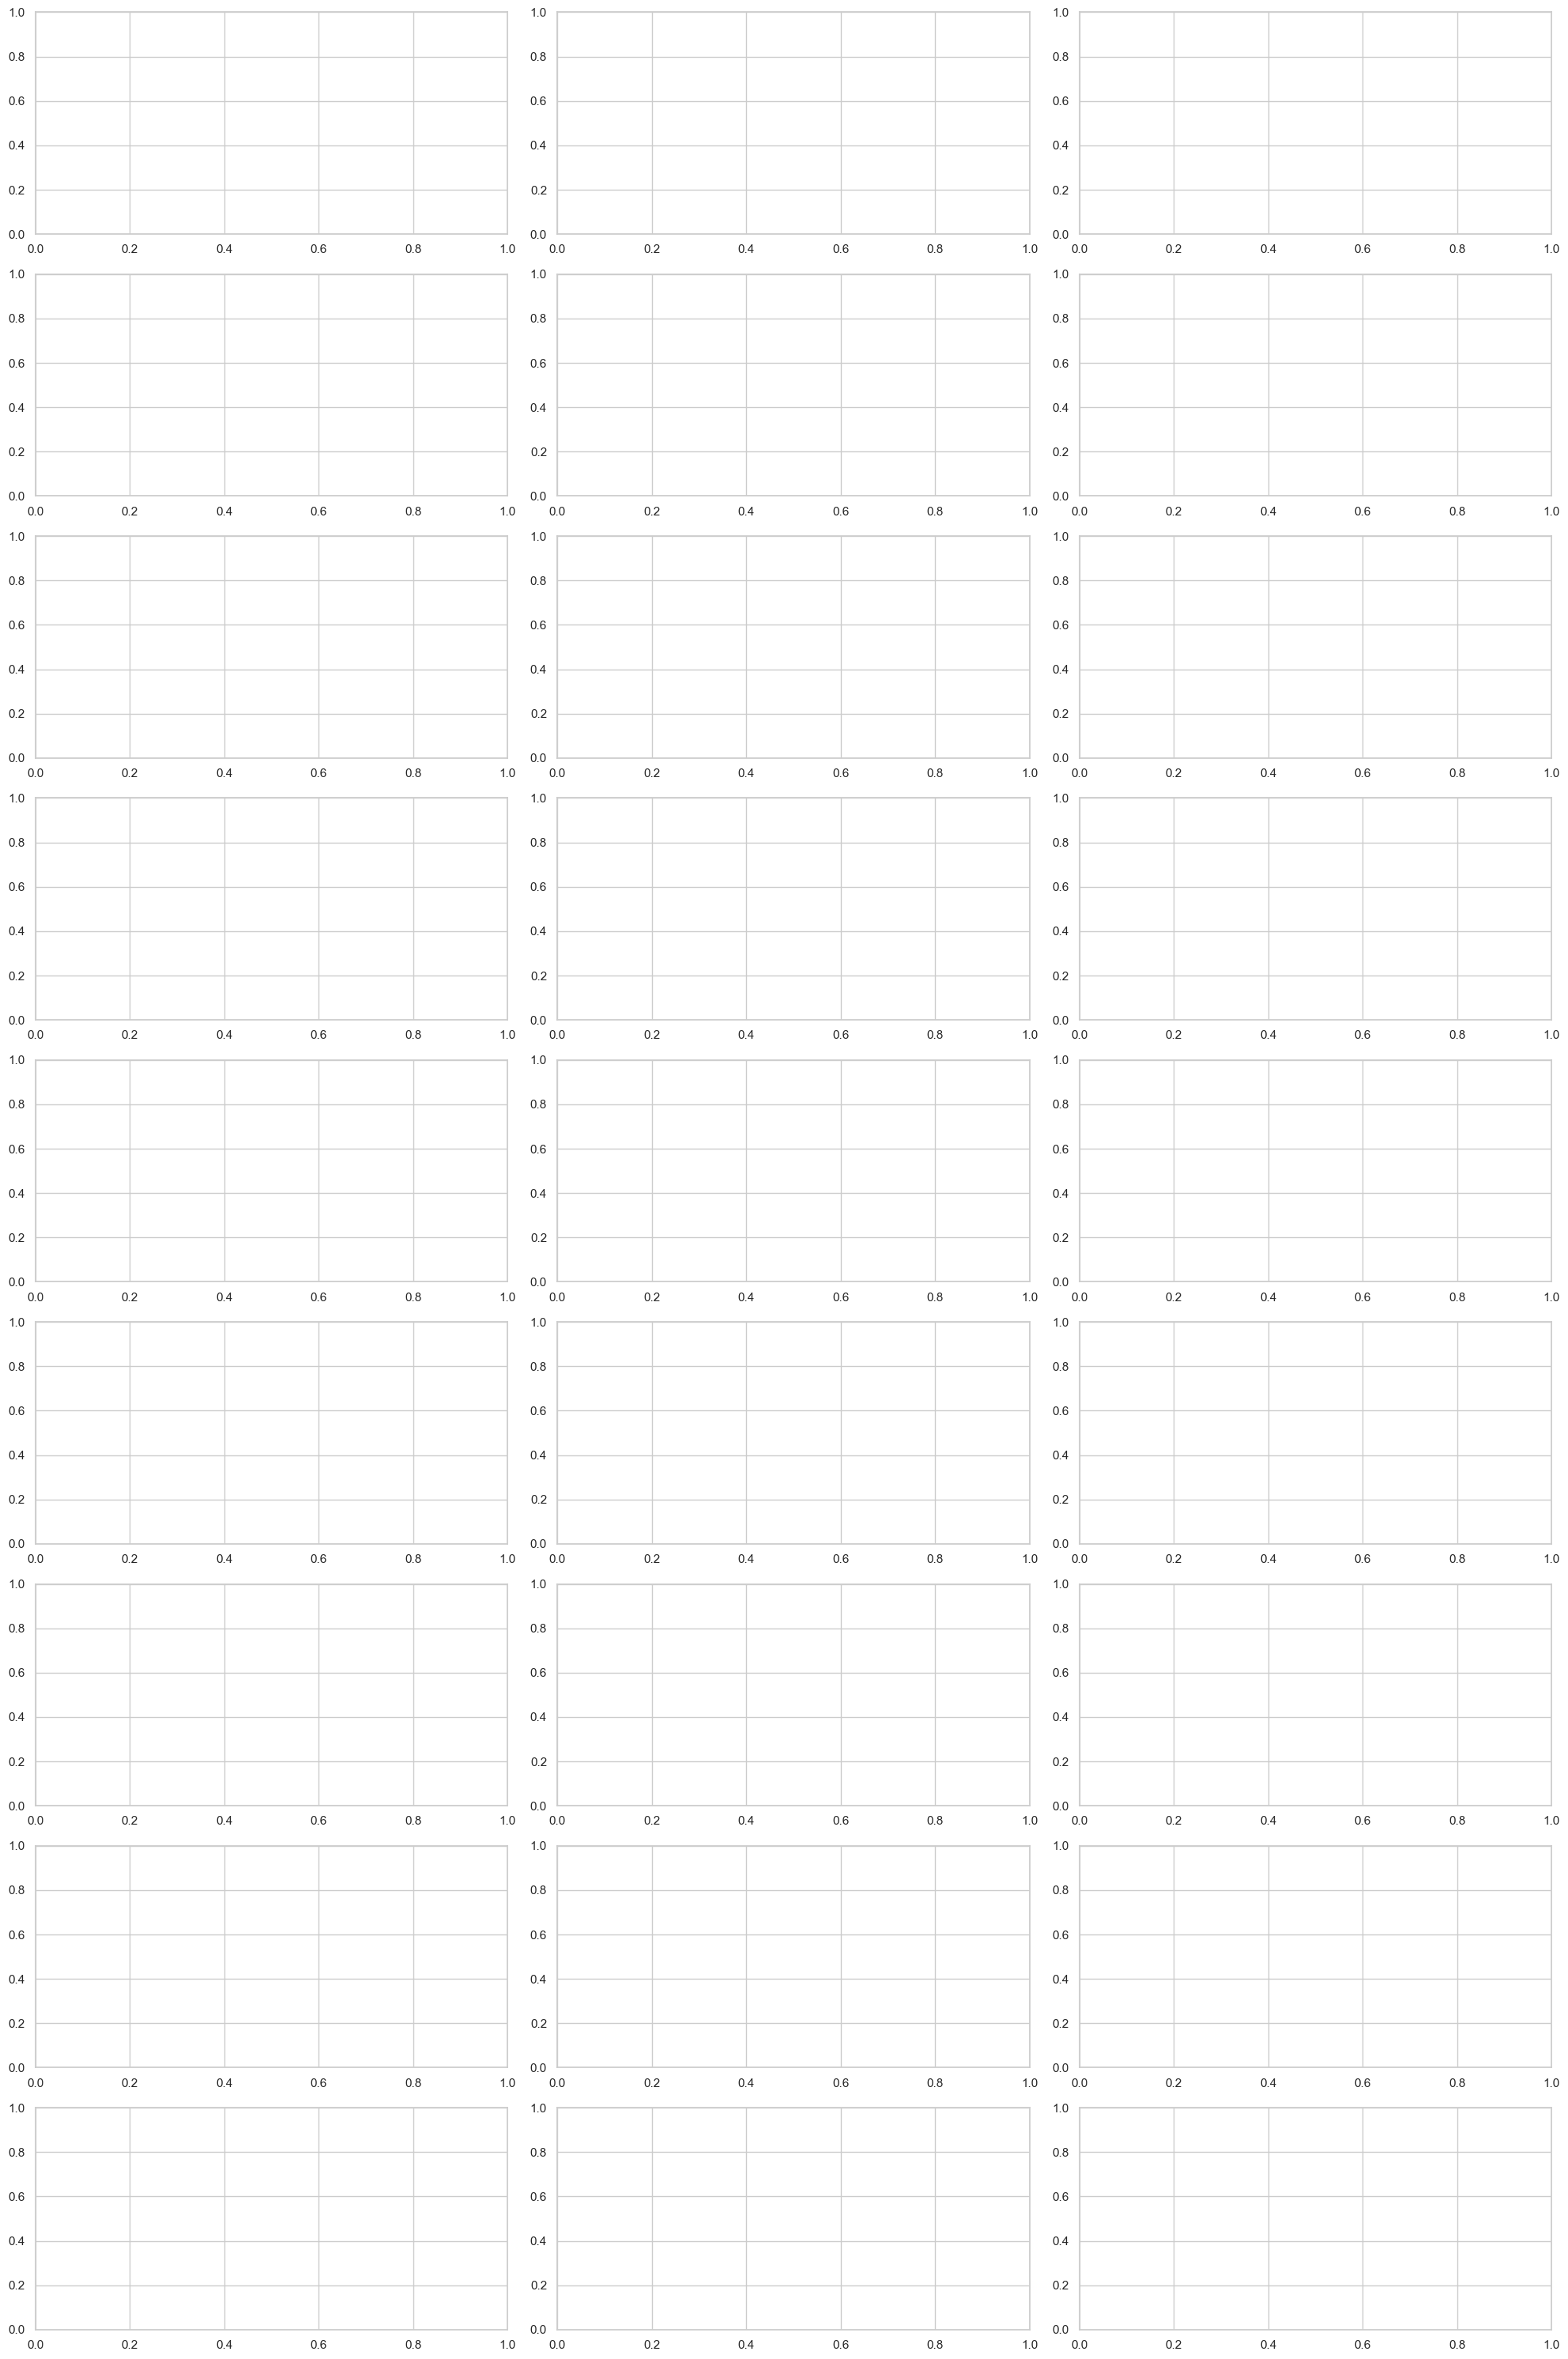

In [339]:
# List of minigames to plot
minigames = sorted((pointMiniGames + ', ' + timeMiniGames).split(', '))  # Add more minigames as needed

fig, ax = plt.subplots(9, 3, figsize=[20, 30])

# Flatten the axes array to iterate over it easily
ax = ax.flatten()

data = getRecordsDataframe(minigame="Replika")
data = data.drop(columns=["Sum"])
replData = data 

# Create swarm plots for each minigame
def createLargeSwarmPlots():
    for i, minigame in enumerate(minigames):
        if "Replika" in minigame: # drop artefact columns for Replika data 
            sns.swarmplot(data=replData, ax=ax[i])
            ax[i].set_title(f"{minigame}")
            ax[i].set_ylabel("")
            ax[i].set_xlabel("")
            ax[i].set_xticks("")
        if "Sammelwahn" in minigame: 
            sns.swarmplot(data=getRecordsDataframe(minigame=minigame), ax=ax[i])
            ax[i].set_title(f"{minigame}")
            ax[i].set_ylabel("")
            ax[i].set_xticks("")
        else:
            sns.swarmplot(data=getRecordsDataframe(minigame=minigame), ax=ax[i])
            ax[i].set_title(f"{minigame}")
            ax[i].set_ylabel("")

    # Hide any remaining empty subplots
    for i in range(len(minigames), len(ax)):
        ax[i].axis('off')

# createLargeSwarmPlots()

plt.tight_layout()
plt.show()


/var/folders/xt/01bddk3n7wg7076w11mqj8640000gn/T/ipykernel_11219/1082916974.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



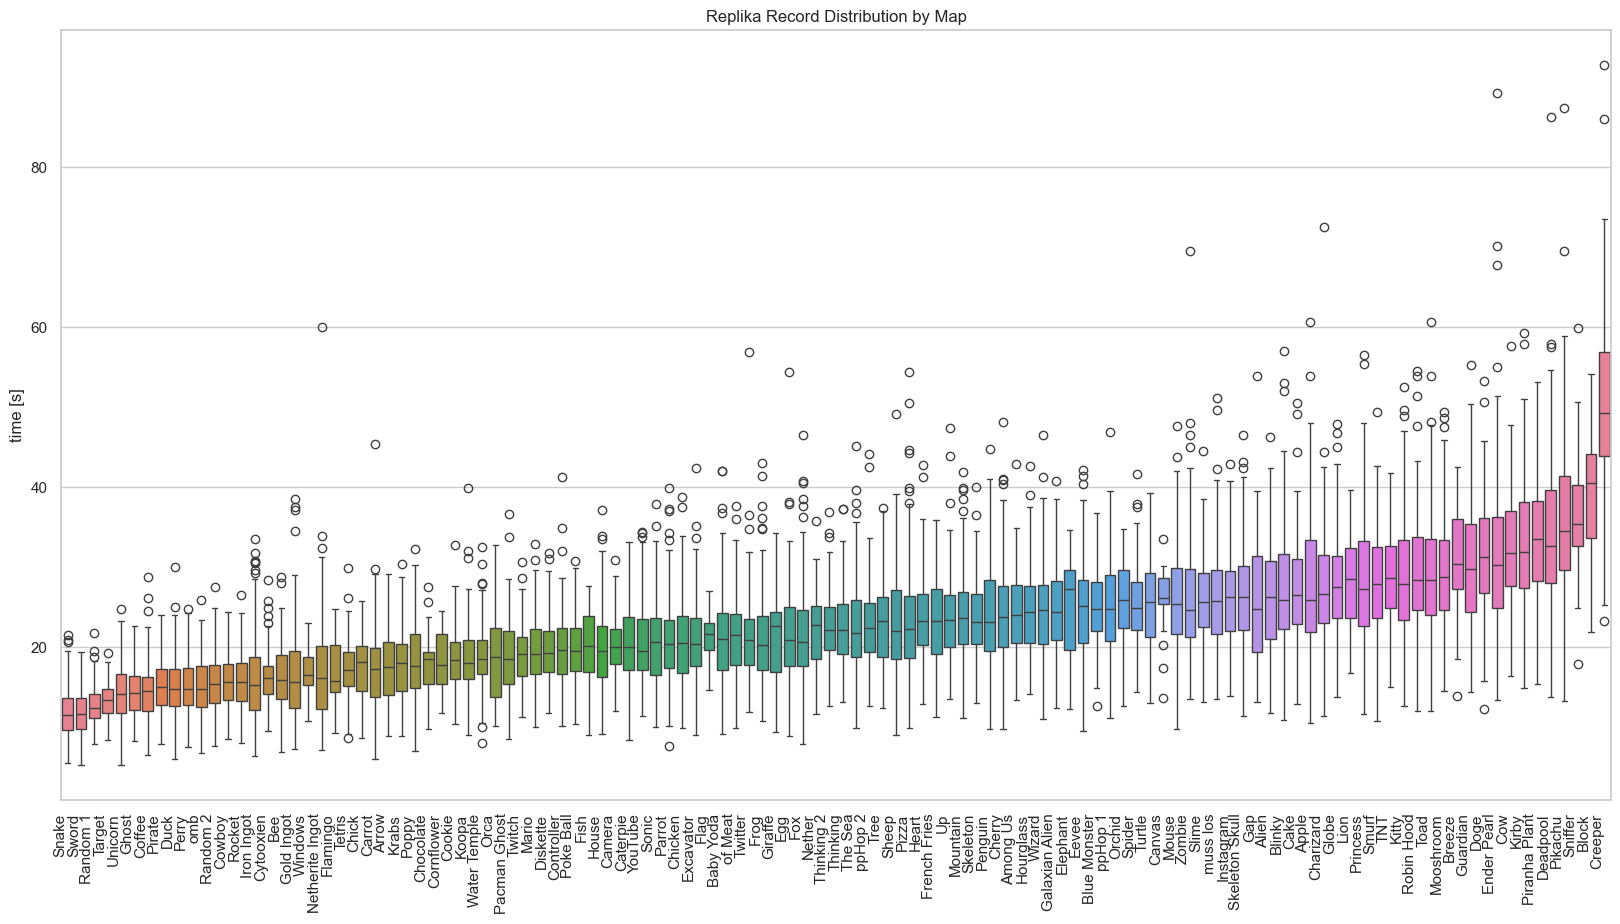

In [340]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the DataFrame for the minigame
data = getRecordsDataframe(minigame="Replika")

# Drop columns "ms Cow" and "ms Sonic"
data = data.drop(columns=["Sum"])
replData = data 

# Calculate mean values for each category
mean_values = data.mean()

# Sort categories based on mean values
sorted_categories = mean_values.sort_values().index

# Reindex the DataFrame using the sorted category order
data_sorted = data.reindex(columns=sorted_categories)

# Create the boxplot
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
sns.boxplot(data=data_sorted)

# Rotate x-axis labels by 90 degrees and align them to the right
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.title("Replika Record Distribution by Map")
plt.ylabel("time [s]")
plt.show()


/var/folders/xt/01bddk3n7wg7076w11mqj8640000gn/T/ipykernel_11219/1181006682.py:24: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



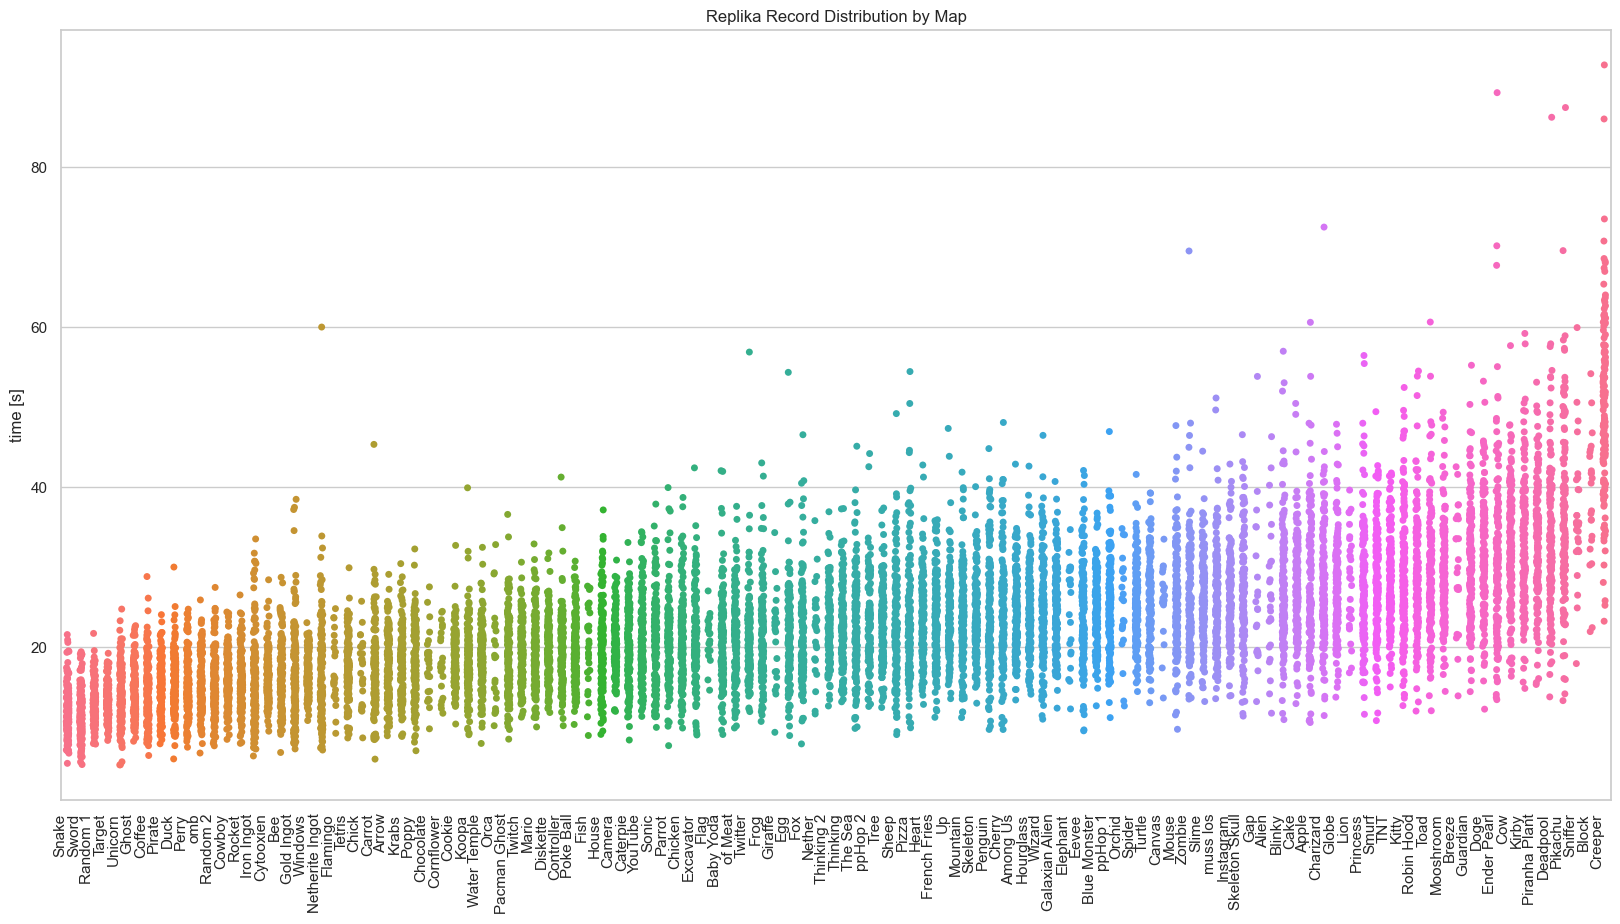

In [341]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the DataFrame for the minigame
data = getRecordsDataframe(minigame="Replika")

# Drop columns "ms Cow" and "ms Sonic"
data = data.drop(columns=['Sum'])

# Calculate mean values for each category
mean_values = data.mean()

# Sort categories based on mean values
sorted_categories = mean_values.sort_values().index

# Reindex the DataFrame using the sorted category order
data_sorted = data.reindex(columns=sorted_categories)

# Create the boxplot
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
sns.stripplot(data=data_sorted)

# Rotate x-axis labels by 90 degrees and align them to the right
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.title("Replika Record Distribution by Map")
plt.ylabel("time [s]")
plt.show()


/var/folders/xt/01bddk3n7wg7076w11mqj8640000gn/T/ipykernel_11219/1812222967.py:23: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



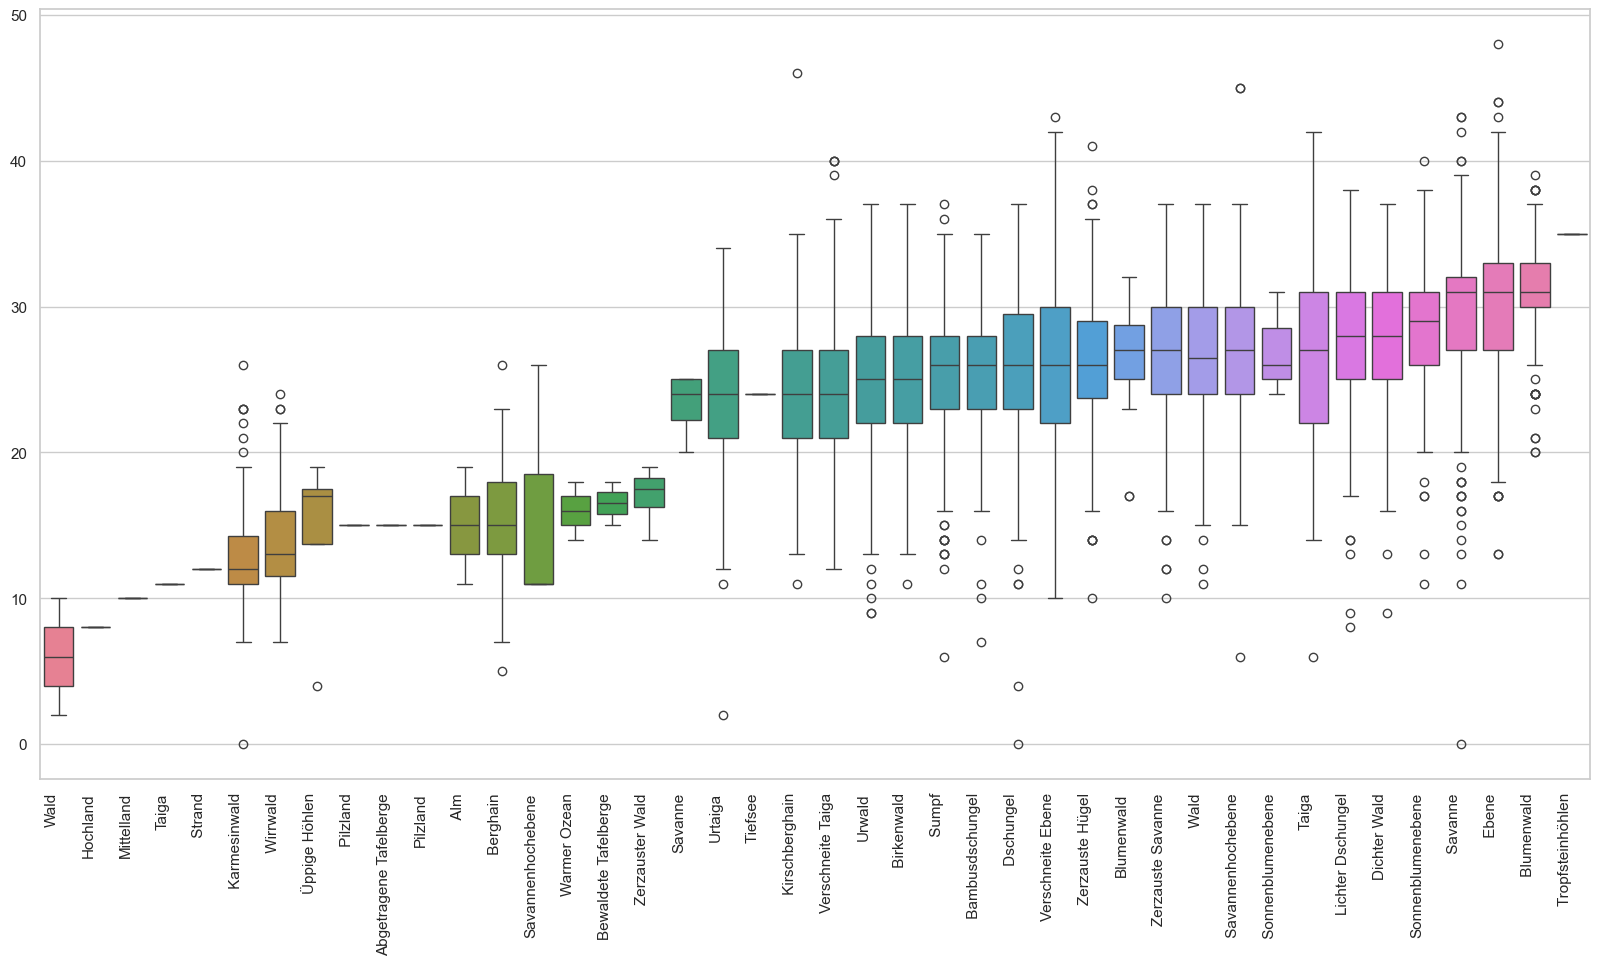

In [342]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the DataFrame for the minigame
data = getRecordsDataframe(minigame="Sammelwahn")

data.drop(columns=['Sum'], inplace=True)

# Calculate mean values for each category
mean_values = data.mean()

# Sort categories based on mean values
sorted_categories = mean_values.sort_values().index

# Reindex the DataFrame using the sorted category order
data_sorted = data.reindex(columns=sorted_categories)

# Create the boxplot
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
sns.boxplot(data=data_sorted)

# Rotate x-axis labels by 90 degrees and align them to the right
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.show()


In [343]:
import plotly.graph_objects as go
import plotly.io as pio
from matplotlib.colors import LinearSegmentedColormap, to_hex

df = getRecordsDataframe(minigame="Replika")

# sort df columns by mean value 
df = df.reindex(df.mean().sort_values().index, axis=1)

# drop sum column
df = df.drop(columns=["Sum"])

# replace 25 with NaN
df = df.replace(25, np.nan)

# remove "ms " from column names
df.columns = df.columns.str.replace('ms ', '')

# Exclude the first column (assuming it's the column you don't want to include)
df_to_html = df.iloc[:, 1:]

# Calculate the offset for centering the data points
num_columns = len(df_to_html.columns)
offset = 0.5

# Create a green to orange gradient
cmap = LinearSegmentedColormap.from_list("green_orange", ["green", "orange"])
colors = [to_hex(cmap(i / (num_columns - 1))) for i in range(num_columns)]

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, (column, color) in enumerate(zip(df_to_html.columns, colors)):
    x_values = [i + offset] * len(df_to_html[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df_to_html[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         line=dict(color=color),
                         fillcolor=color,
                         hovertext=df_to_html.index,
                         hoverinfo='name+text+y',
                         showlegend=True))

fig.update_layout(title="Replika Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

# Show the figure
fig.show()

# Export the plot to an HTML file
pio.write_html(fig, "out/repl_swarm_plot.html")

In [344]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Sammelwahn")

# sort df columns by mean value 
df = df.reindex(df.mean().sort_values().index, axis=1)

# drop sum column
df = df.drop(columns=["Sum"])

# remove "Punkte" from all columns
df.columns = df.columns.str.replace('Punkte', '')

cmap = LinearSegmentedColormap.from_list("green_orange", ["green", "orange"])
colors = [to_hex(cmap(i / (num_columns - 1))) for i in range(num_columns)]

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, (column, color) in enumerate(zip(df.columns, colors)):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         line=dict(color=color),
                         fillcolor=color,
                         hovertext=df_to_html.index,
                         hoverinfo='name+text+y',
                         showlegend=True))

fig.update_layout(title="Too Many Items Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/sammel_swarm_plot.html")

In [345]:
data = getRecordsDataframe(minigame="Replika")

In [346]:
data.columns.tolist()

['Sum',
 'Alien',
 'Among Us',
 'Apple',
 'Arrow',
 'Baby Yoda',
 'Bee',
 'Blinky',
 'Block',
 'Blue Monster',
 'Breeze',
 'Cake',
 'Camera',
 'Canvas',
 'Carrot',
 'Caterpie',
 'Charizard',
 'Cherry',
 'Chick',
 'Chicken',
 'Chocolate',
 'Coffee',
 'Controller',
 'Cookie',
 'Cornflower',
 'Cow',
 'Cowboy',
 'Creeper',
 'Cytooxien',
 'Deadpool',
 'Diskette',
 'Doge',
 'Duck',
 'Eevee',
 'Egg',
 'Elephant',
 'Ender Pearl',
 'Excavator',
 'Fish',
 'Flag',
 'Flamingo',
 'Fox',
 'French Fries',
 'Frog',
 'Galaxian Alien',
 'Gap',
 'Ghost',
 'Giraffe',
 'Globe',
 'Gold Ingot',
 'Guardian',
 'Heart',
 'Hourglass',
 'House',
 'Instagram',
 'Iron Ingot',
 'Kirby',
 'Kitty',
 'Koopa',
 'Krabs',
 'Lion',
 'Mario',
 'Mooshroom',
 'Mountain',
 'Mouse',
 'Nether',
 'Netherite Ingot',
 'Orca',
 'Orchid',
 'Pacman Ghost',
 'Parrot',
 'Penguin',
 'Perry',
 'Pikachu',
 'Piranha Plant',
 'Pirate',
 'Pizza',
 'Poke Ball',
 'Poppy',
 'Princess',
 'Random 1',
 'Random 2',
 'Robin Hood',
 'Rocket',
 'Sheep'